<a href="https://colab.research.google.com/github/jhwnoh/UST2024Fall_MaterialsInformatics/blob/main/AEtoVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image

In [17]:
TorchModule = {'linear':nn.Linear,
               'conv1d':nn.Conv1d,
               'conv2d':nn.Conv2d,
               'conv3d':nn.Conv3d,
               'convtrans1d':nn.ConvTranspose1d,
               'convtrans2d':nn.ConvTranspose2d,
               'convtrans3d':nn.ConvTranspose3d,
               'maxpool1d':nn.MaxPool1d,
               'maxpool2d':nn.MaxPool2d,
               'maxpool3d':nn.MaxPool3d,
               'sigmoid':nn.Sigmoid(),
               'tanh':nn.Tanh(),
               'relu':nn.ReLU(),
               'lrelu':nn.LeakyReLU(),
               'bn1d':nn.BatchNorm1d,
               'bn2d':nn.BatchNorm2d,
               'bn3d':nn.BatchNorm3d}

def LayerGroup(mylayers):
    mylayer_list = mylayers.split('|')

    module_list = []
    for mylayer in mylayer_list:
        if '-' in mylayer:
            tmp = mylayer.split('-')

            name = tmp[0]
            dims = [int(v) for v in tmp[1].split(',')]

            if name == 'linear':
                sub_model = TorchModule[name](*dims)
            elif 'conv' in name:
                sub_model = TorchModule[name](*dims)
            elif 'pool' in name:
                sub_model = TorchModule[name](*dims)

            module_list.append(sub_model)

        else:
            module_list.append(TorchModule[mylayer])

    module_list = nn.ModuleList(module_list)
    return nn.Sequential(*module_list)

In [5]:
mylayers = 'linear-100,50|tanh|linear-50,10|relu|linear-10,1'
my_model = LayerGroup(mylayers).cuda()
my_model

Sequential(
  (0): Linear(in_features=100, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [7]:
x = torch.randn(10,100).cuda()
y = my_model(x)
print(y.shape)

torch.Size([10, 1])


In [52]:
class Autoencoder(nn.Module):
    def __init__(self,enc_info,dec_info):
        super(Autoencoder,self).__init__()

        self.encoder = LayerGroup(enc_info)
        self.decoder = LayerGroup(dec_info)

    def forward(self,x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z,out

enc_info = 'linear-784,512|relu|linear-512,20'
dec_info = 'linear-20,512|relu|linear-512,784|sigmoid'

my_autoencoder = Autoencoder(enc_info,dec_info).cuda()

print(my_autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [45]:
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    root="./",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="./",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [46]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [53]:
from tqdm import tqdm

optimizer = torch.optim.Adam(my_autoencoder.parameters(), lr=0.001)

num_epoch = 10

Loss = []
for epoch in range(num_epoch):
    print('============= Epoch: '+str(epoch+1)+' =============')
    my_autoencoder.train()

    L1 = 0
    N1 = 0
    for x,y in tqdm(train_dataloader):
        x = x.cuda().view(-1,28*28)

        z,x_pred = my_autoencoder(x)

        loss = torch.mean((x_pred-x)**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        L1 += len(x)*loss.detach().cpu().numpy()
        N1 += len(x)

    my_autoencoder.eval()
    Zs = []
    Xs = []
    Ys = []

    L2 = 0
    N2 = 0
    for x,y in tqdm(test_dataloader):
        x = x.cuda().view(-1,28*28)

        z,x_pred = my_autoencoder(x)

        loss = torch.mean((x_pred-x)**2)

        L2 += len(x)*loss.detach().cpu().numpy()
        N2 += len(x)

        Zs.append(z.detach().cpu().numpy())
        Xs.append(x_pred.detach().cpu().numpy())
        Ys.append(y.detach().cpu().numpy())

    Loss.append([L1/N1,L2/N2])
    print(Loss[-1])

Loss = np.array(Loss)
Zs = np.vstack(Zs)
Xs = np.vstack(Xs)
Ys = np.hstack(Ys)

============= Epoch: 1 =============


100%|██████████| 157/157 [00:01<00:00, 137.24it/s]


[0.02458011348048846, 0.012617839121818542]
============= Epoch: 2 =============


100%|██████████| 157/157 [00:01<00:00, 135.10it/s]


[0.011720407678186894, 0.010474132476747037]
============= Epoch: 3 =============


100%|██████████| 157/157 [00:01<00:00, 103.89it/s]


[0.010149962118764719, 0.009463770231604576]
============= Epoch: 4 =============


100%|██████████| 157/157 [00:01<00:00, 129.03it/s]


[0.009315771088500818, 0.008927177393436432]
============= Epoch: 5 =============


100%|██████████| 157/157 [00:01<00:00, 135.54it/s]


[0.008774724068741004, 0.008576623919606209]
============= Epoch: 6 =============


100%|██████████| 157/157 [00:01<00:00, 134.37it/s]


[0.008371609835326671, 0.008229368499666453]
============= Epoch: 7 =============


100%|██████████| 157/157 [00:01<00:00, 138.34it/s]


[0.008066947381695111, 0.00803663758188486]
============= Epoch: 8 =============


100%|██████████| 157/157 [00:01<00:00, 136.49it/s]


[0.007813222043216229, 0.007834801878035069]
============= Epoch: 9 =============


100%|██████████| 157/157 [00:01<00:00, 113.80it/s]


[0.007619811114172141, 0.0077305853962898255]
============= Epoch: 10 =============


100%|██████████| 157/157 [00:01<00:00, 136.32it/s]

[0.007439723677933216, 0.007582337285578251]


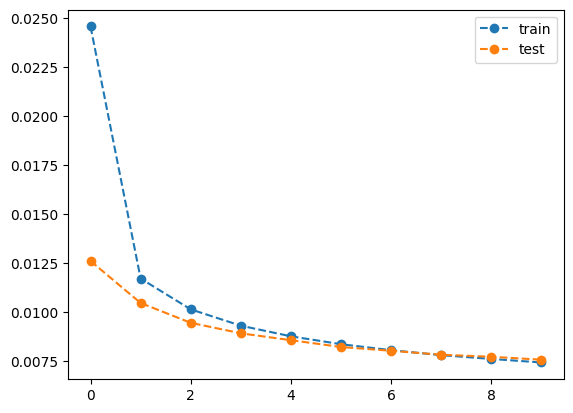

In [54]:
import matplotlib.pyplot as plt

Loss = np.array(Loss)
plt.plot(Loss[:,0],'o--',label='train')
plt.plot(Loss[:,1],'o--',label='test')
plt.legend()

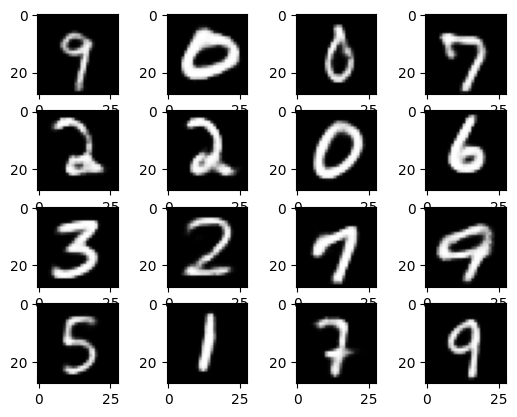

In [55]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(Xs[i].reshape(28,28),cmap='gray')

In [96]:
class ConvAE(nn.Module):
    def __init__(self,enc_info,dec_info):
        super(ConvAE,self).__init__()

        self.encoder = LayerGroup(enc_info)
        self.decoder = LayerGroup(dec_info)

    def forward(self,x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z,out

enc_info = 'conv2d-1,16,3,1,1|relu|maxpool2d-2,2,0|conv2d-16,32,3,1,1|relu|maxpool2d-2,2,0|conv2d-32,32,7,7,0'
dec_info = 'convtrans2d-32,32,7,7,0|relu|convtrans2d-32,32,6,2,2|relu|convtrans2d-32,1,6,2,2|sigmoid'

my_conv_autoencoder = ConvAE(enc_info,dec_info).cuda()
print(my_conv_autoencoder)

x = torch.randn(10,1,28,28).cuda()
z,x_pred = my_conv_autoencoder(x)
print(x.shape)
print(z.shape)
print(x_pred.shape)

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(7, 7), stride=(7, 7))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(7, 7), stride=(7, 7))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (5): Sigmoid()
  )
)
torch.Size([10, 1, 28, 28])
torch.Size([10, 32, 1, 1])
torch.Size([10, 1, 28, 28])


In [98]:
from tqdm import tqdm

optimizer = torch.optim.Adam(my_conv_autoencoder.parameters(), lr=0.001)

num_epoch = 10

Loss = []
for epoch in range(num_epoch):
    print('============= Epoch: '+str(epoch+1)+' =============')
    my_conv_autoencoder.train()

    L1 = 0
    N1 = 0
    for x,y in tqdm(train_dataloader):
        x = x.cuda()

        z,x_pred = my_conv_autoencoder(x)

        loss = torch.mean((x_pred-x)**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        L1 += len(x)*loss.detach().cpu().numpy()
        N1 += len(x)

    my_conv_autoencoder.eval()
    Zs = []
    Xs = []
    Ys = []

    L2 = 0
    N2 = 0
    for x,y in tqdm(test_dataloader):
        x = x.cuda()

        z,x_pred = my_conv_autoencoder(x)

        loss = torch.mean((x_pred-x)**2)

        L2 += len(x)*loss.detach().cpu().numpy()
        N2 += len(x)

        Zs.append(z.detach().cpu().numpy().reshape(-1,32))
        Xs.append(x_pred.detach().cpu().numpy())
        Ys.append(y.detach().cpu().numpy())

    Loss.append([L1/N1,L2/N2])
    print(Loss[-1])

Loss = np.array(Loss)
Zs = np.vstack(Zs)
Xs = np.vstack(Xs)
Ys = np.hstack(Ys)

============= Epoch: 1 =============


100%|██████████| 157/157 [00:01<00:00, 106.94it/s]


[0.007902540832509597, 0.006336035232245922]
============= Epoch: 2 =============


100%|██████████| 157/157 [00:01<00:00, 106.45it/s]


[0.005818734598408142, 0.005230796080827713]
============= Epoch: 3 =============


100%|██████████| 157/157 [00:01<00:00, 103.97it/s]


[0.005095369161168734, 0.00487990455776453]
============= Epoch: 4 =============


100%|██████████| 157/157 [00:01<00:00, 107.21it/s]


[0.004724109391619762, 0.004575991939753294]
============= Epoch: 5 =============


100%|██████████| 157/157 [00:01<00:00, 106.53it/s]


[0.004493026885638634, 0.004489614086598158]
============= Epoch: 6 =============


100%|██████████| 157/157 [00:01<00:00, 108.40it/s]


[0.004324138016750415, 0.004233820550143719]
============= Epoch: 7 =============


100%|██████████| 157/157 [00:01<00:00, 105.82it/s]


[0.004197678080076973, 0.004197940833866596]
============= Epoch: 8 =============


100%|██████████| 157/157 [00:01<00:00, 104.58it/s]


[0.004099480171501637, 0.004109628103673458]
============= Epoch: 9 =============


100%|██████████| 157/157 [00:01<00:00, 105.48it/s]


[0.004014996639639139, 0.003977423540130257]
============= Epoch: 10 =============


100%|██████████| 157/157 [00:01<00:00, 107.63it/s]

[0.003950905083616575, 0.004006468565762043]


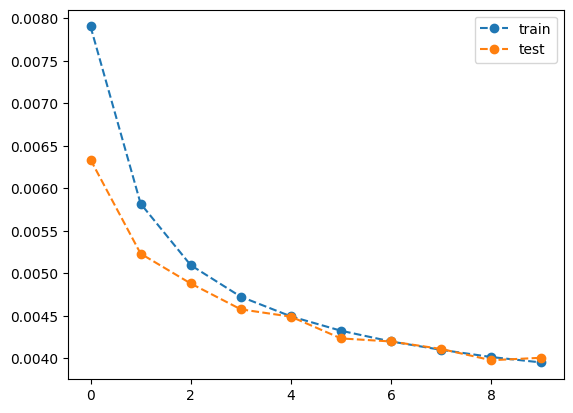

In [99]:
import matplotlib.pyplot as plt

Loss = np.array(Loss)
plt.plot(Loss[:,0],'o--',label='train')
plt.plot(Loss[:,1],'o--',label='test')
plt.legend()

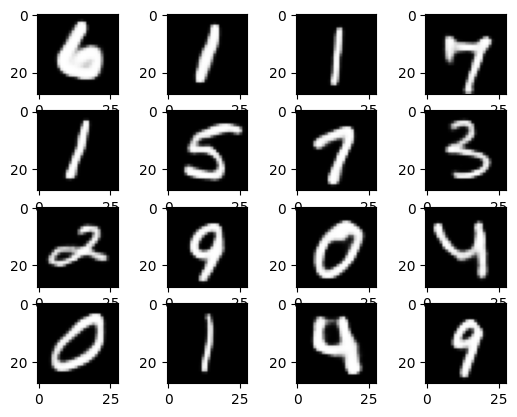

In [100]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(Xs[i].reshape(28,28),cmap='gray')

In [109]:
class ConvVAE(nn.Module):
    def __init__(self,enc_info,dec_info):
        super(ConvVAE,self).__init__()

        self.encoder = LayerGroup(enc_info)
        self.decoder = LayerGroup(dec_info)

    def forward(self,x):
        h = self.encoder(x)

        mu = h[:,:32]
        logvar = h[:,32:]

        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std

        out = self.decoder(z)
        return z,out,mu,logvar

enc_info = 'conv2d-1,16,3,1,1|relu|maxpool2d-2,2,0|conv2d-16,32,3,1,1|relu|maxpool2d-2,2,0|conv2d-32,64,7,7,0'
dec_info = 'convtrans2d-32,32,7,7,0|relu|convtrans2d-32,32,6,2,2|relu|convtrans2d-32,1,6,2,2|sigmoid'

my_conv_vae = ConvVAE(enc_info,dec_info).cuda()
print(my_conv_vae)

x = torch.randn(10,1,28,28).cuda()
z,x_pred,_,_ = my_conv_vae(x)
print(x.shape)
print(z.shape)
print(x_pred.shape)

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(7, 7), stride=(7, 7))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(7, 7), stride=(7, 7))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (5): Sigmoid()
  )
)
torch.Size([10, 1, 28, 28])
torch.Size([10, 32, 1, 1])
torch.Size([10, 1, 28, 28])


In [132]:
from tqdm import tqdm

optimizer = torch.optim.Adam(my_conv_vae.parameters(), lr=0.0003)

num_epoch = 10

Loss = []
for epoch in range(num_epoch):
    print('============= Epoch: '+str(epoch+1)+' =============')
    my_conv_vae.train()

    L1 = 0
    N1 = 0
    for x,y in tqdm(train_dataloader):
        x = x.cuda()

        z,x_pred,mu,logvar = my_conv_vae(x)

        rec = torch.mean((x_pred-x)**2)
        kld = torch.mean(-0.5*(1 + logvar - mu ** 2 - logvar.exp()))

        loss = rec + 0.02*kld

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        L1 += len(x)*rec.detach().cpu().numpy()
        N1 += len(x)

    my_conv_vae.eval()
    Zs = []
    Xs = []
    Ys = []

    L2 = 0
    N2 = 0
    for x,y in tqdm(test_dataloader):
        x = x.cuda()

        z,x_pred,mu,logvar = my_conv_vae(x)

        rec = torch.mean((x_pred-x)**2)
        kld = torch.mean(-0.5*(1 + logvar - mu ** 2 - logvar.exp()))

        L2 += len(x)*rec.detach().cpu().numpy()
        N2 += len(x)

        Zs.append(z.detach().cpu().numpy().reshape(-1,32))
        Xs.append(x_pred.detach().cpu().numpy())
        Ys.append(y.detach().cpu().numpy())

    Loss.append([L1/N1,L2/N2])
    print(Loss[-1])

Loss = np.array(Loss)
Zs = np.vstack(Zs)
Xs = np.vstack(Xs)
Ys = np.hstack(Ys)

============= Epoch: 1 =============


100%|██████████| 157/157 [00:01<00:00, 104.75it/s]


[0.013199892560144266, 0.013585144811868668]
============= Epoch: 2 =============


100%|██████████| 157/157 [00:01<00:00, 101.69it/s]


[0.013419440614183743, 0.013565485155582428]
============= Epoch: 3 =============


100%|██████████| 157/157 [00:01<00:00, 103.93it/s]


[0.013513771834969521, 0.013513912902772427]
============= Epoch: 4 =============


100%|██████████| 157/157 [00:01<00:00, 103.61it/s]


[0.013534761295715968, 0.013668827757239342]
============= Epoch: 5 =============


100%|██████████| 157/157 [00:01<00:00, 100.89it/s]


[0.013596930909653505, 0.013542025075852872]
============= Epoch: 6 =============


100%|██████████| 157/157 [00:01<00:00, 95.67it/s]


[0.013608049348493417, 0.013704830086231232]
============= Epoch: 7 =============


100%|██████████| 157/157 [00:02<00:00, 62.53it/s]


[0.013616139272848765, 0.01352719981521368]
============= Epoch: 8 =============


100%|██████████| 157/157 [00:02<00:00, 75.66it/s]


[0.01362456088066101, 0.01366304753869772]
============= Epoch: 9 =============


100%|██████████| 157/157 [00:01<00:00, 90.47it/s]


[0.013625390091538429, 0.013471098227798938]
============= Epoch: 10 =============


100%|██████████| 157/157 [00:01<00:00, 100.81it/s]

[0.013622687511642775, 0.01352797267884016]


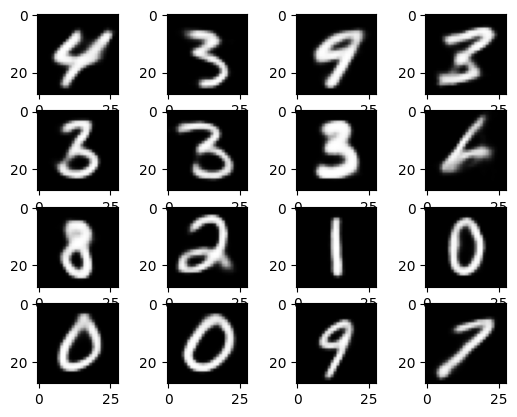

In [133]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(Xs[i].reshape(28,28),cmap='gray')

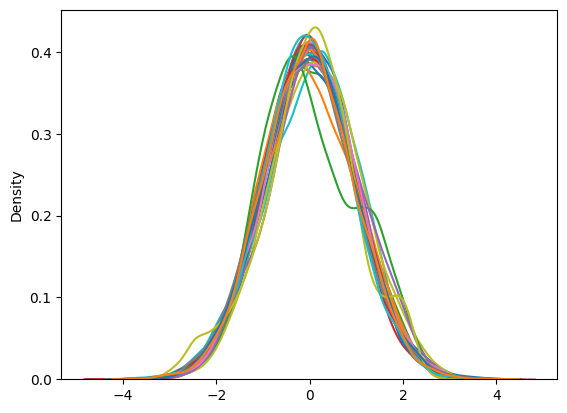

In [134]:
import seaborn as sns

for i in range(32):
    sns.kdeplot(Zs[:,i])

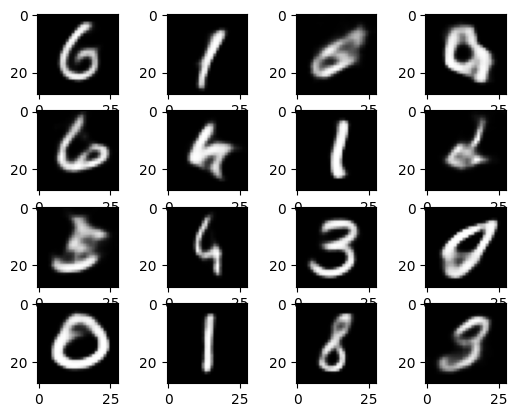

In [138]:
z = torch.randn(16,32,1,1).cuda()
x_new = my_conv_vae.decoder(z).cpu().detach().numpy()

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_new[i].reshape(28,28),cmap='gray')